# REDES NUERONALES RECURRENTES

Implementacion con un set de sañales trigonometricas.

## Funciones comunes a todas la partes

In [ ]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [ ]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [ ]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [ ]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            #print(y.shape)
            #y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            #print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                #y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

## Primera aproximación de recurrencia, empleado un perceptrón multicapa.
(adapación de un MLP para predecir el valor futuro de un señal)



In [ ]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


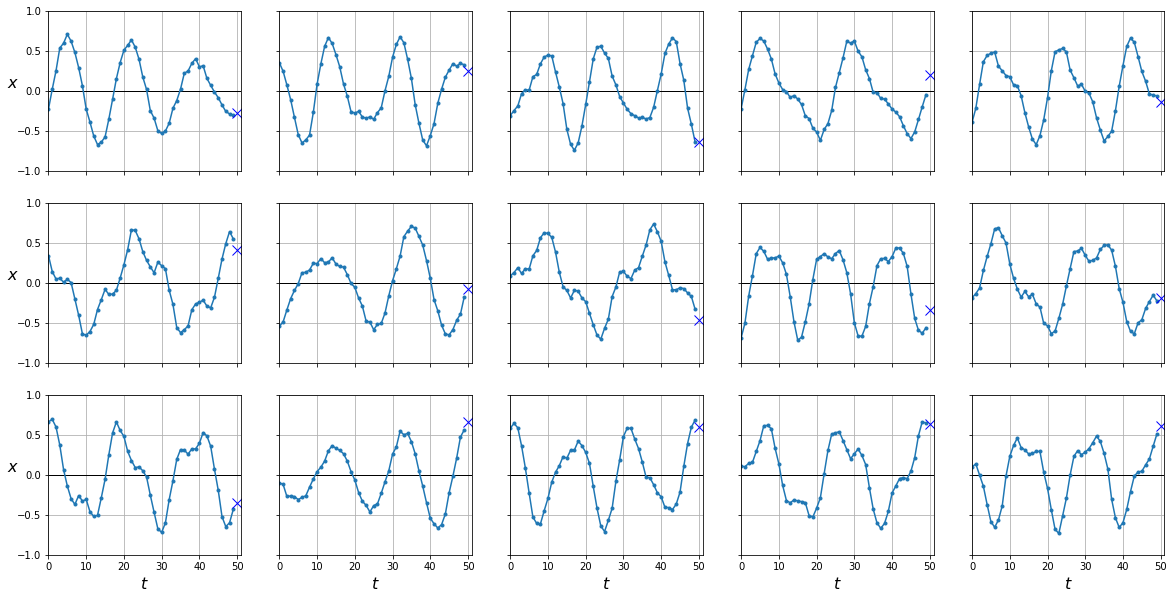

In [ ]:
plot_series(X_test, y_test)

In [ ]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

MLP para comparar luego con RNN

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
fit(mlp, dataloader)

epoch numero:  0


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
train_loss 0.15313:  82%|████████▏ | 90/110 [00:00<00:00, 179.36it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
valid_loss 0.13916:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is

epoch numero:  1


valid_loss 0.13864: 100%|██████████| 32/32 [00:00<00:00, 313.37it/s]


epoch numero:  2


valid_loss 0.13847: 100%|██████████| 32/32 [00:00<00:00, 272.91it/s]


epoch numero:  3


valid_loss 0.13839: 100%|██████████| 32/32 [00:00<00:00, 208.11it/s]


epoch numero:  4


valid_loss 0.13839: 100%|██████████| 32/32 [00:00<00:00, 222.41it/s]


epoch numero:  5


valid_loss 0.13834: 100%|██████████| 32/32 [00:00<00:00, 237.29it/s]


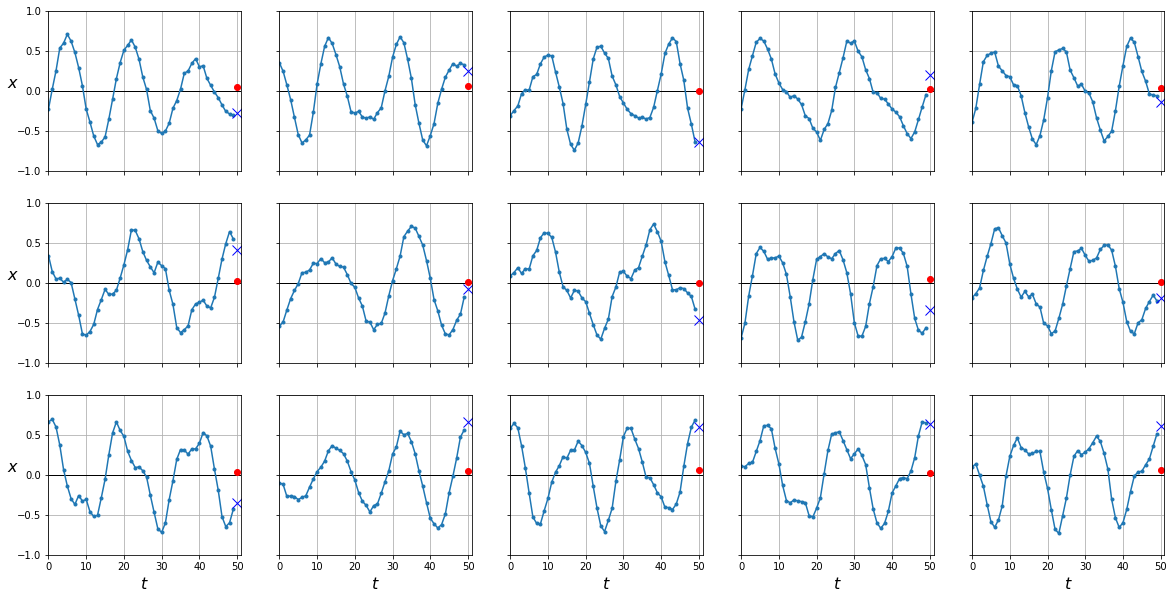

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.13545683

In [ ]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

## Veamos ahora una RNN básica de 1 sola neurona

In [ ]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # solo queremos la última salidas
    #return x[:,-10:]
    return x[:,-1:,-1]

rnn = SimpleRNN()
rnn

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [ ]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.0882, 0.5191, 0.5218, 0.1752, 0.0136, 0.5129, 0.0497, 0.2053, 0.5294,
        0.2892, 0.3746, 0.0172, 0.0973, 0.1488, 0.2645, 0.9944, 0.2916, 0.1834,
        0.3294, 0.6271, 0.1907, 0.4264, 0.6327, 0.9403, 0.7445, 0.1558, 0.4094,
        0.2188, 0.0748, 0.7901, 0.1115, 0.1679, 0.6715, 0.4963, 0.9282, 0.3051,
        0.3453, 0.0775, 0.7548, 0.6365, 0.9039, 0.3555, 0.8162, 0.5800, 0.4254,
        0.0859, 0.4562, 0.5743, 0.4969, 0.1263])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [ ]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.1968]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [ ]:
# ahora el vamos a pasar un set del dataset...

In [ ]:

# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como input:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como input:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [ ]:
nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn(serie[None,:])
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)


input shape:
torch.Size([50, 1])
salida de la red (largo igual al input):
torch.Size([1, 1])
tamaño del valor deseado:
torch.Size([1, 1])


In [ ]:
fit(rnn, dataloader)

epoch numero:  0


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
train_loss 0.19378:  94%|█████████▎| 103/110 [00:01<00:00, 92.74it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
valid_loss 0.16804:  88%|████████▊ | 28/32 [00:00<00:00, 139.25it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1]

epoch numero:  1


valid_loss 0.15509: 100%|██████████| 32/32 [00:00<00:00, 149.99it/s]


epoch numero:  2


valid_loss 0.14923: 100%|██████████| 32/32 [00:00<00:00, 143.44it/s]


epoch numero:  3


valid_loss 0.14553: 100%|██████████| 32/32 [00:00<00:00, 141.26it/s]


epoch numero:  4


valid_loss 0.14299: 100%|██████████| 32/32 [00:00<00:00, 144.22it/s]


epoch numero:  5


valid_loss 0.14126: 100%|██████████| 32/32 [00:00<00:00, 155.75it/s]


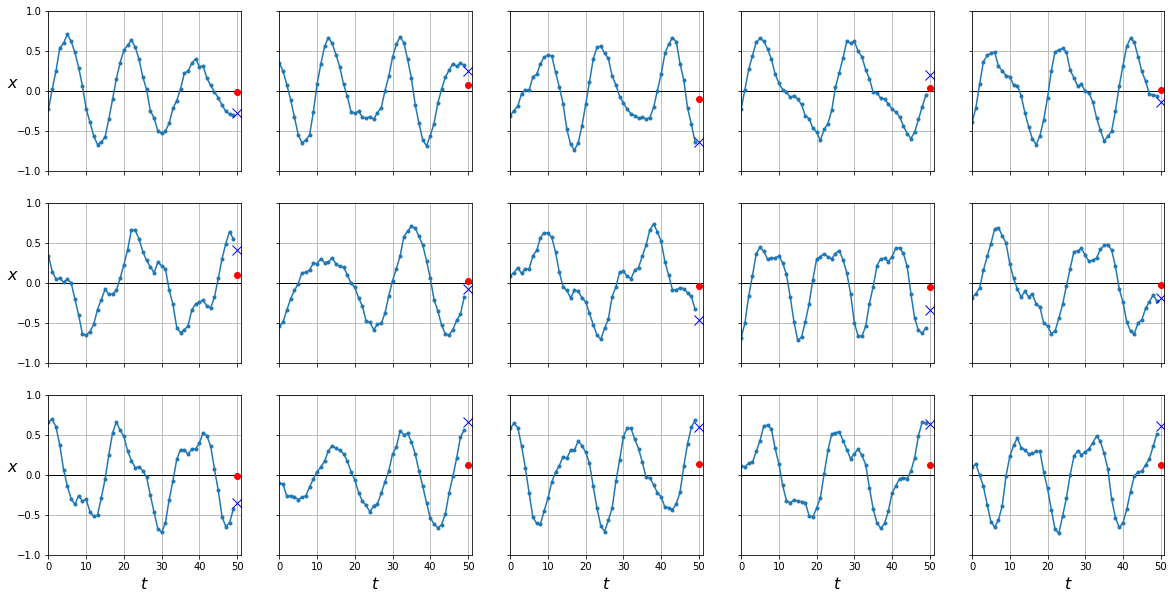

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.10047239

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

## Comparacion de parámetros entre MLP y RNN implementada

In [ ]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [ ]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])



## Incorporamos más neuronas en la RNN

In [ ]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_2 = RNN()

In [ ]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [ ]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.1648, 0.9549, 0.6204, 0.9234, 0.3820, 0.4075, 0.7267, 0.9314, 0.1994,
        0.3759, 0.9011, 0.4882, 0.1069, 0.7923, 0.4509, 0.5406, 0.4335, 0.0689,
        0.9631, 0.2436])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [ ]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.1384]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 1])


In [ ]:
fit(rnn_2, dataloader)

epoch numero:  0


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
train_loss 0.14649:  95%|█████████▍| 104/110 [00:01<00:00, 68.20it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
valid_loss 0.13789:  88%|████████▊ | 28/32 [00:00<00:00, 133.69it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1]

epoch numero:  1


valid_loss 0.13835: 100%|██████████| 32/32 [00:00<00:00, 146.54it/s]


epoch numero:  2


valid_loss 0.13823: 100%|██████████| 32/32 [00:00<00:00, 141.99it/s]


epoch numero:  3


valid_loss 0.13819: 100%|██████████| 32/32 [00:00<00:00, 141.60it/s]


epoch numero:  4


valid_loss 0.13817: 100%|██████████| 32/32 [00:00<00:00, 140.59it/s]


epoch numero:  5


valid_loss 0.13835: 100%|██████████| 32/32 [00:00<00:00, 123.98it/s]


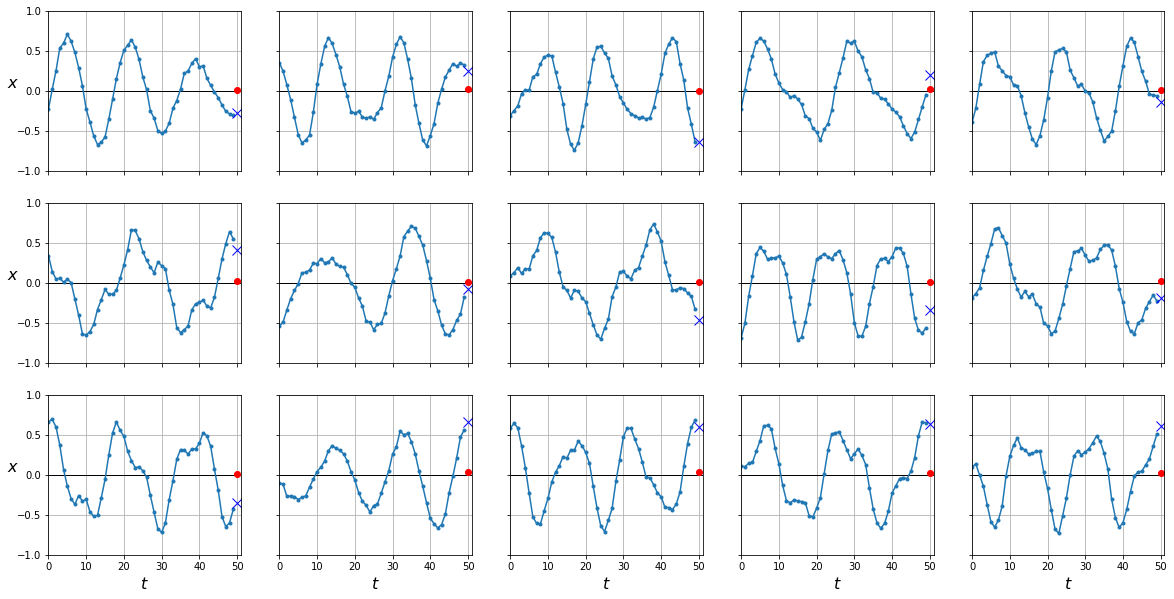

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.13483144

In [ ]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Le agregamos 1 layer mas, para tener mas profundidad





In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [ ]:
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)

epoch numero:  0


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
train_loss 0.14496:  95%|█████████▌| 105/110 [00:01<00:00, 58.43it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
valid_loss 0.13875:  75%|███████▌  | 24/32 [00:00<00:00, 112.43it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1]

epoch numero:  1


valid_loss 0.13870: 100%|██████████| 32/32 [00:00<00:00, 127.43it/s]


epoch numero:  2


valid_loss 0.13827: 100%|██████████| 32/32 [00:00<00:00, 116.68it/s]


epoch numero:  3


valid_loss 0.13819: 100%|██████████| 32/32 [00:00<00:00, 133.17it/s]


epoch numero:  4


valid_loss 0.13843: 100%|██████████| 32/32 [00:00<00:00, 125.14it/s]


epoch numero:  5


valid_loss 0.13818: 100%|██████████| 32/32 [00:00<00:00, 111.51it/s]


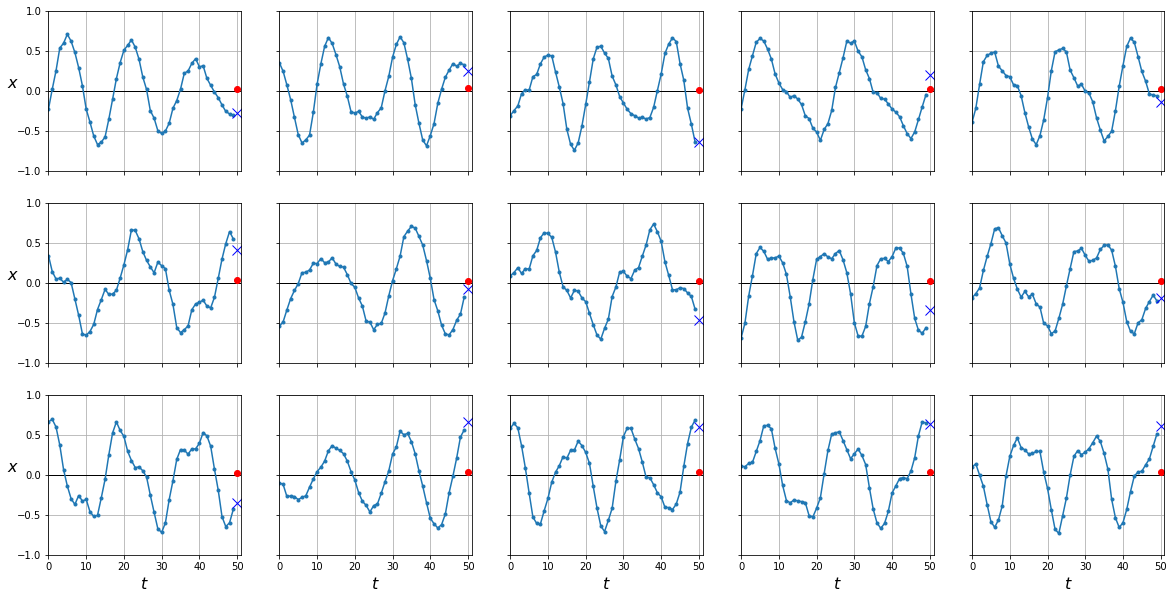

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.13390024

In [ ]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

In [ ]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



# predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


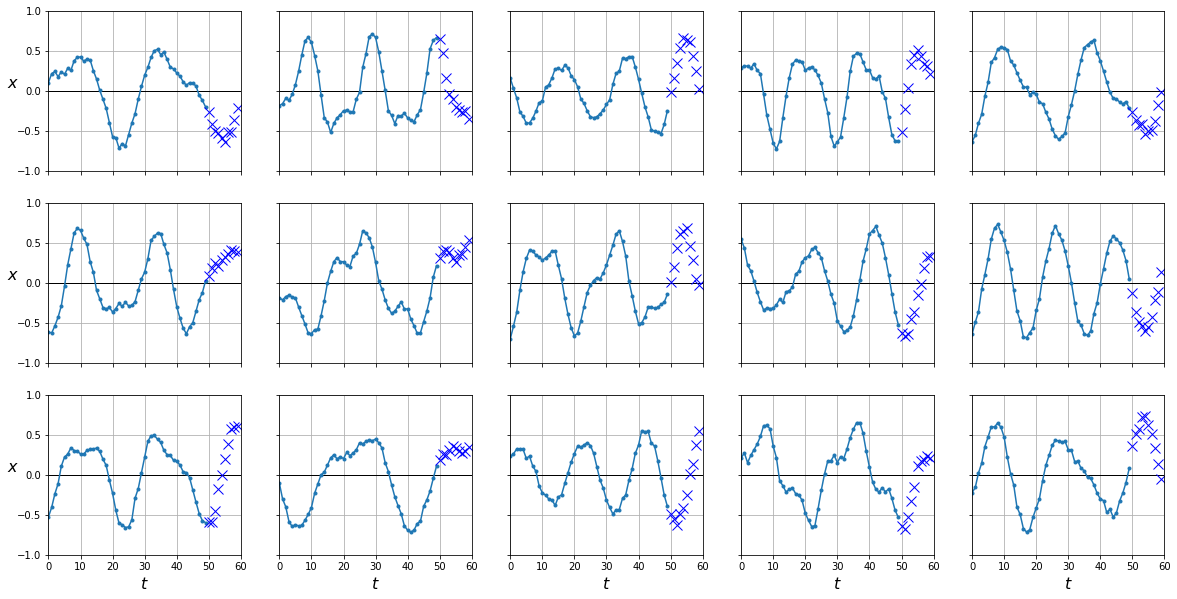

(1000, 10, 1)
(1000, 1, 1)


In [ ]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [ ]:
#  tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:1,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:1,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:1,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


In [ ]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [ ]:
# entreno de nueva la ultima red y graficamos
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)


epoch numero:  0


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
train_loss 0.14699:  95%|█████████▌| 105/110 [00:01<00:00, 57.62it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
valid_loss 0.14898:  94%|█████████▍| 30/32 [00:00<00:00, 137.00it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1]

epoch numero:  1


valid_loss 0.14772: 100%|██████████| 32/32 [00:00<00:00, 127.72it/s]


epoch numero:  2


valid_loss 0.14783: 100%|██████████| 32/32 [00:00<00:00, 117.49it/s]


epoch numero:  3


valid_loss 0.14734: 100%|██████████| 32/32 [00:00<00:00, 114.01it/s]


epoch numero:  4


valid_loss 0.14726: 100%|██████████| 32/32 [00:00<00:00, 123.00it/s]


epoch numero:  5


valid_loss 0.14725: 100%|██████████| 32/32 [00:00<00:00, 117.61it/s]


In [ ]:
print(xs.shape)
#predict(rnn_deep, xs)
sal = rnn_deep(xs)
sal.shape

torch.Size([64, 50, 1])


torch.Size([64, 1])

(1000, 10)


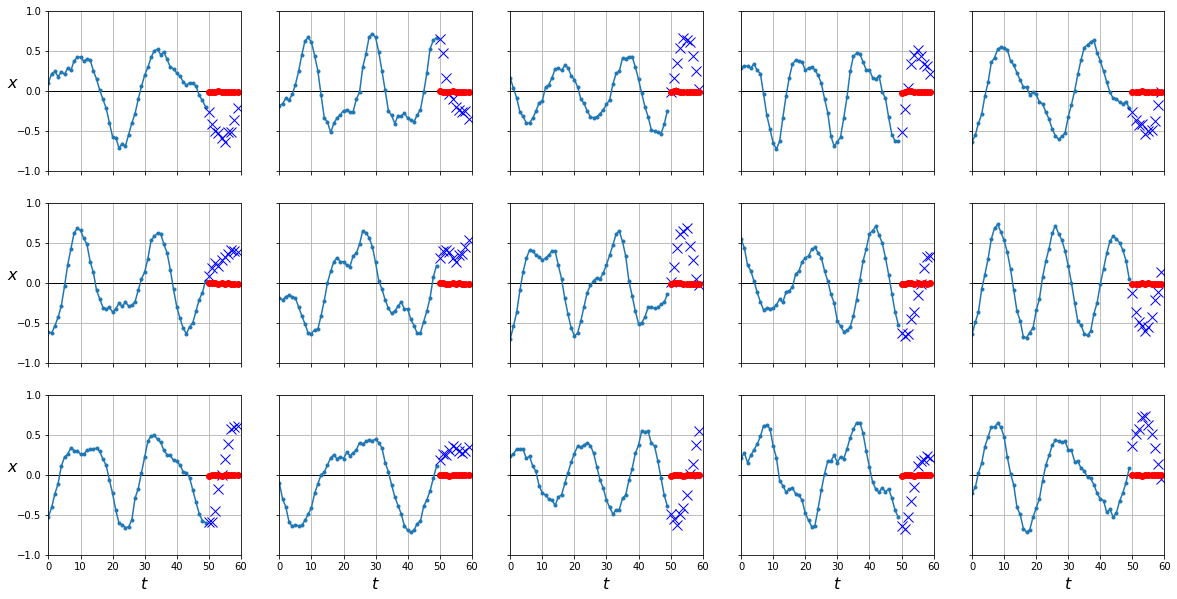

(1000, 10, 1)
(1000, 10)


0.14189646

In [ ]:
# graficamos

X = X_test
for step_ahead in range(10):
    #print(step_ahead)
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0) # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    #print(inputs.shape)
    y_pred_one = predict(rnn_deep, inputs).cpu().numpy()
    #print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
    #print(X.shape)

y_pred = X[:, n_steps:, -1]
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

epoch numero:  0


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
train_loss 0.14745:  98%|█████████▊| 108/110 [00:00<00:00, 158.06it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
valid_loss 0.14750:  56%|█████▋    | 18/32 [00:00<00:00, 174.97it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1

epoch numero:  1


valid_loss 0.14744: 100%|██████████| 32/32 [00:00<00:00, 400.94it/s]


epoch numero:  2


valid_loss 0.14750: 100%|██████████| 32/32 [00:00<00:00, 376.55it/s]


epoch numero:  3


valid_loss 0.14748: 100%|██████████| 32/32 [00:00<00:00, 203.60it/s]


epoch numero:  4


valid_loss 0.14750: 100%|██████████| 32/32 [00:00<00:00, 230.00it/s]


epoch numero:  5


valid_loss 0.14744: 100%|██████████| 32/32 [00:00<00:00, 361.71it/s]


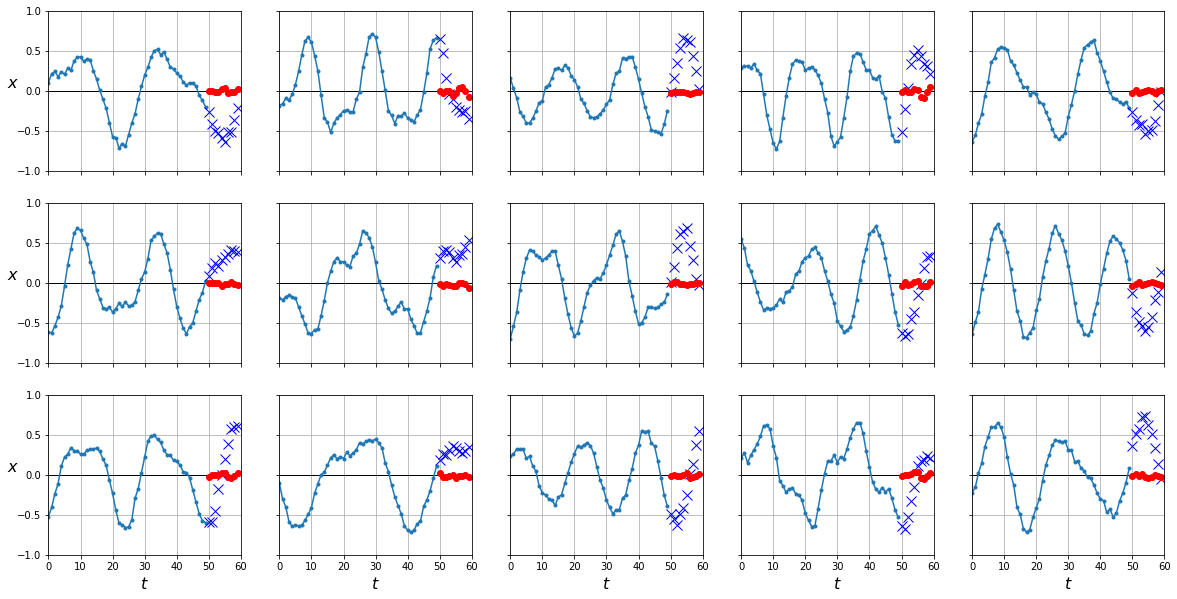

(1000, 10, 1)
(1000, 10)


0.1452578

In [ ]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)


# Crear una RNN que tenga 10 salidas y mejore el error del MLP usado antes. Asegurarse de compararlos con el mismo set datos!!

In [ ]:
rnn_deep

DeepRNN(
  (rnn): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
class DeepRNN_Noutputs(torch.nn.Module):
  def __init__(self):
    super().__init__()
    h = 50
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=h, num_layers=5, batch_first=True)
    outputs = 1
    self.fc = torch.nn.Linear(h, outputs)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-10:])
    return x

In [ ]:
rnn_deep_Noutputs = DeepRNN_Noutputs()
rnn_deep_Noutputs

DeepRNN_Noutputs(
  (rnn): RNN(1, 50, num_layers=5, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
rnn_deep_Noutputs.forward(xs).shape

torch.Size([64, 10, 1])

In [ ]:
#  Armo un nuevo dataloader que pase 10 valores a futuro
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:10,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:10,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:10,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))

<class 'dict'>


In [ ]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.8332, 0.5709, 0.5137, 0.2288, 0.3190, 0.0705, 0.4424, 0.2086, 0.0872,
        0.3869, 0.3399, 0.2932, 0.2818, 0.0632, 0.1611, 0.4133, 0.3289, 0.8995,
        0.2838, 0.9201, 0.6118, 0.3960, 0.0875, 0.8315, 0.1928, 0.2894, 0.3240,
        0.7092, 0.1394, 0.2257, 0.7770, 0.8143, 0.5686, 0.0585, 0.2324, 0.9329,
        0.8509, 0.8103, 0.1860, 0.3266, 0.1115, 0.1315, 0.9566, 0.8565, 0.1309,
        0.9221, 0.7768, 0.2644, 0.7586, 0.2510])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [ ]:
# paso la entrada a la red
salida = rnn_deep_Noutputs(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[[-0.2624],
         [-0.2559],
         [-0.2607],
         [-0.2561],
         [-0.2496],
         [-0.2596],
         [-0.2608],
         [-0.2507],
         [-0.2646],
         [-0.2636]]], grad_fn=<AddBackward0>)
salida shape:
torch.Size([1, 10, 1])


In [ ]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 10, 1])


In [ ]:
rnn_deep_Noutputs(xs).shape

torch.Size([64, 10, 1])

In [ ]:
fit(rnn_deep_Noutputs, dataloader)

epoch numero:  0


valid_loss 0.06084: 100%|██████████| 32/32 [00:00<00:00, 58.25it/s]


epoch numero:  1


valid_loss 0.03780: 100%|██████████| 32/32 [00:00<00:00, 59.43it/s]


epoch numero:  2


valid_loss 0.03062: 100%|██████████| 32/32 [00:00<00:00, 60.21it/s]


epoch numero:  3


valid_loss 0.02243: 100%|██████████| 32/32 [00:00<00:00, 55.79it/s]


epoch numero:  4


valid_loss 0.01627: 100%|██████████| 32/32 [00:00<00:00, 65.29it/s]


epoch numero:  5


valid_loss 0.00968: 100%|██████████| 32/32 [00:00<00:00, 53.94it/s]


(1000, 10, 1)


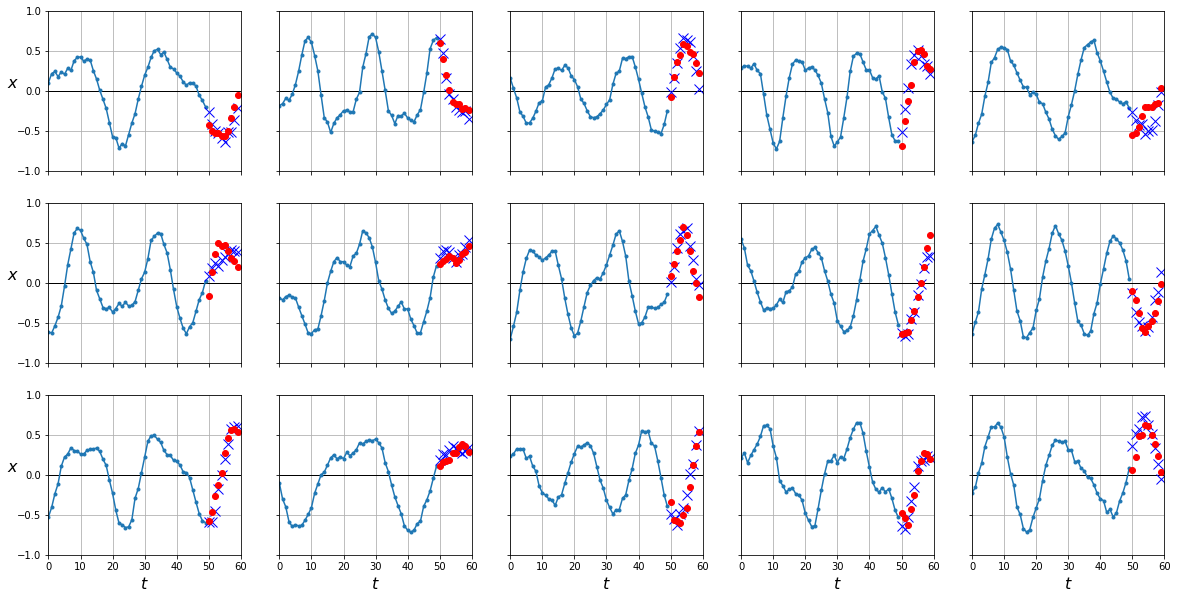

(1000, 10, 1)
(1000, 10, 1)


0.010906501

In [ ]:
X = X_test
inputs = torch.from_numpy(X[:, 10:]).unsqueeze(0)
y_pred = predict(rnn_deep_Noutputs, inputs).cpu().numpy()
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

# CONCLUSIÓN

Fue posible crear una RNN con 5 layers y con 50 neuronas en cada capa hidden que proporcionó un error de test inferior al del MLP realizando una predicción simultanea de los 10 pasos de tiempo futuros (a diferencia del MLP que utiliza una predicción secuencial de los 10 pasos de tiempo futuros), 